
This code is used for calculating the realspace density autocorrelation function between Dark Matter halos
using the Corrfunc open package, DD module 
and compare with my code F-corrfunc

Input data: using file contains 164014 mock halos (attached with this code)
There are 2 cases to compare:
1. Non PBC, logspace bins
2. Non PBC, linearspace bins

The matter power spectrum used for Linear theory calculation was calculated using a public code called CLASS and saved in the file 'power_spectrum.txt', attached with this code.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
from hankel import HankelTransform
from datetime import datetime
from scipy.interpolate import InterpolatedUnivariateSpline as spline 
path='/Users/ngoc/Desktop/Master-study/project'

In [2]:
#cosmological parameters
z        = 0.306
Omg_lamb = 0.685
Omg_m    = 1 - Omg_lamb
a        = 1/(1 + z)
E_a      = np.sqrt(Omg_m*(1+z)**3 + Omg_lamb)

In [3]:
#simulation parameter
boxsize  = 2000          #[Mpc/h]
nthreads = 4            #The number of OpenMP threads to use
autocorr = 1 
nbins    = 50             #number of bins
r_min    = 1               #[Mpc/h]
r_max    = boxsize/3       #[Mpc/h]
bins     = np.logspace(np.log10(r_min), np.log10(r_max), nbins + 1)


The 1st simulation case: logspace bins and non PBC

Need to create random halos and count pair, however Corrfunc does not provide random pair count and Python did very slow so I adopt the random pair count from F-corrfunc to use for Corrfunc too.

The time measured here just the time for calculate DD pair count and $\xi$

Load my F-corrfunc results for non PBC, logspace case

Total duration time: 211.98550800000001       seconds.

Time for calculate only DD pair count: 101.21834900000000      seconds

In [4]:
#load my F-corrfunc results for non PBC 
xi_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace.txt', usecols = (3))
r_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace.txt', usecols = (2))
RR_f =  np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace.txt', usecols = (1))
DD_f =  np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace.txt', usecols = (0))
print(r_f)
print(xi_f)
print(RR_f)

[  1.07749188   1.23617826   1.40078557   1.59145477   1.80766742
   2.05948888   2.33410052   2.66289914   3.02591538   3.44904747
   3.92893268   4.47698356   5.09406538   5.80841132   6.60487353
   7.52547029   8.57558262   9.75684201  11.12459301  12.66805606
  14.43283001  16.4330044   18.72091039  21.32985031  24.28632774
  27.66512052  31.51193492  35.89902725  40.89102334  46.5694442
  53.03765925  60.40398763  68.80314912  78.36404111  89.24903195
 101.63191002 115.74206864 131.82083133 150.13160051 170.97509793
 194.72082426 221.75469418 252.54467517 287.6028577  327.52567221
 372.99307341 424.76513131 483.70541826 550.83265424 627.25225537]
[-5.00000000e-01  2.80000000e+00  8.66666667e+00  2.60000000e+01
  3.04615385e+01  2.84761905e+01  1.84285714e+01  2.69736842e+01
  1.74864865e+01  1.50900000e+01  1.21410256e+01  9.40400000e+00
  7.74380165e+00  6.18198529e+00  4.91044776e+00  4.23734729e+00
  3.17939815e+00  2.51203416e+00  2.14395604e+00  1.57473949e+00
  1.20296909e+0

In [5]:
start_time2 = datetime.now()

In [6]:

#load positions of halos
X = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (3))
    
weights = np.full_like(X,1)
#calculate data-data pairs
results_DD = DD(autocorr,
                nthreads,
                bins,
                X, Y, Z,
                weights1    = weights,
                boxsize     = boxsize,
                weight_type = 'pair_product',
                output_ravg = True,
                periodic    = False) 

In [7]:
npair  = results_DD['npairs']
weight = results_DD['weightavg']
xi  = npair*weight/RR_f  - 1
r   = results_DD['ravg']

In [8]:
end_time2 = datetime.now()
print('Duration: {}'.format(end_time2 - start_time2))

Duration: 0:00:07.963482


In [9]:
# Linear theory
b = 3.11
k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))
P_k = spline(k, P)
h0  = HankelTransform(nu=1/2, N = 2000, h = 1e-3)

# xi density in real space
f_0 = lambda k: P_k(k)*k**(1/2)/(np.pi*2)**(3/2)
xi_dd_r_theory = 1/np.sqrt(r)*h0.transform(f_0,r, ret_err=False, inverse=True)*b**2

Text(0.5, 1.0, '$\\xi_{dd}$ with logspace bins, non PBC')

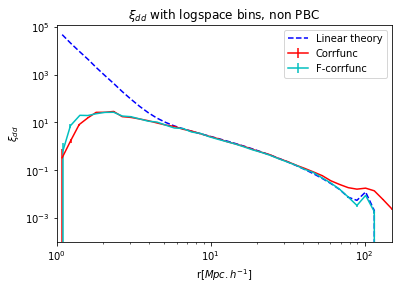

In [24]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.errorbar(r, xi, fmt='r-', yerr = (1+xi)/np.sqrt(npair), label='Corrfunc')
ax.errorbar(r_f, xi_f, fmt='c-', yerr = (1+xi_f)/np.sqrt(DD_f), label='F-corrfunc')
ax.plot(r, xi_dd_r_theory,'b--',label='Linear theory')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(1,1.5e2)
ax.set_title('$\\xi_{dd}$ with logspace bins, non PBC')
#plt.savefig('xi_dd_logspace_nonPBC.png')

Text(0.5, 1.0, '$\\xi_{dd}$ logspace bins, non PBC')

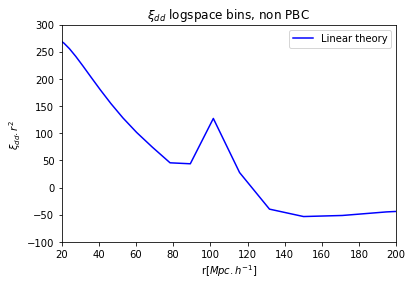

In [11]:
ax = plt.axes()
#ax.set_xscale("log")
#ax.set_yscale("log")
#ax.errorbar(r, xi*r**2, fmt='r-', yerr = (1+xi)/np.sqrt(npair), label='Corrfunc')
#ax.errorbar(r_f, xi_f, fmt='c-', yerr = (1+xi_f)/np.sqrt(DD_f), label='F-corrfunc')
ax.plot(r, xi_dd_r_theory*r**2,'b-',label='Linear theory')
ax.set_ylabel("$\\xi_{dd}.r^2$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(20,200)
ax.set_ylim(-100,3e2)
ax.set_title('$\\xi_{dd}$ logspace bins, non PBC')
#plt.savefig('xi_dd_logspace_nonPBC.png')

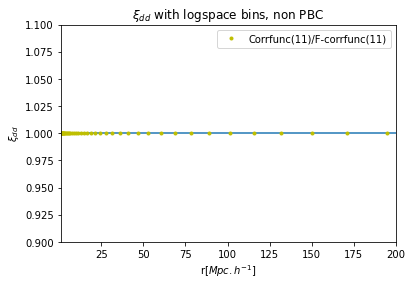

In [12]:
ax = plt.axes()
yy = np.full_like(r,1)
#ax.set_xscale("log")
#ax.set_yscale("log")
ax.plot(r,yy,'-')
#ax.plot(r, xi/xi_dd_r_theory, 'b*', label='Corrfunc(11)/Linear')
ax.plot(r, xi/xi_f, 'y.', label='Corrfunc(11)/F-corrfunc(11)')
#ax.plot(r_f, xi_f/xi_dd_r_theory, 'r--', label='F-corrfunc(11)/Linear')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(1,2e2)
ax.set_ylim(0.9,1.1)
ax.set_title('$\\xi_{dd}$ with logspace bins, non PBC')
plt.savefig('xi_dd_logspace_nonPBC-compare11.png')

In [13]:
#load my F-corrfunc results for non PBC, data file 12
xi_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace12.txt', usecols = (3))
r_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace12.txt', usecols = (2))
RR_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace12.txt', usecols = (1))

In [14]:

#load positions of halos
X = np.loadtxt(path+'/catalogs/12/gals/2gpc/R112_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/12/gals/2gpc/R112_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/12/gals/2gpc/R112_S014_clu_d.cat', usecols = (3))
    
weights = np.full_like(X,1)
#calculate data-data pairs
results_DD = DD(autocorr,
                nthreads,
                bins,
                X, Y, Z,
                weights1 = weights,
                boxsize=boxsize,
                weight_type = 'pair_product',
                output_ravg=True,
                periodic=False) 

In [15]:
npair  = results_DD['npairs']
weight = results_DD['weightavg']
xi  = npair*weight/RR_f  - 1
r   = results_DD['ravg']

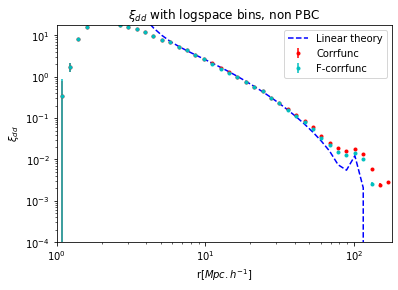

In [16]:
ax = plt.axes()
#yy = np.full_like(r,1)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.plot(r,yy,'-')
ax.errorbar(r, xi, fmt='r.', yerr = (1+xi)/np.sqrt(npair), label='Corrfunc')
ax.errorbar(r_f, xi_f, fmt='c.', yerr = (1+xi_f)/np.sqrt(DD_f), label='F-corrfunc')
ax.plot(r, xi_dd_r_theory,'b--',label='Linear theory')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(1,1.8e2)
ax.set_ylim(1e-4,18)
ax.set_title('$\\xi_{dd}$ with logspace bins, non PBC')
plt.savefig('xi_dd_logspace12.png')

In [17]:
#load my F-corrfunc results for non PBC, data file 14
xi_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace14.txt', usecols = (3))
r_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace14.txt', usecols = (2))
RR_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-logspace14.txt', usecols = (1))

In [18]:

#load positions of halos
X = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (3))
    
weights = np.full_like(X,1)
#calculate data-data pairs
results_DD = DD(autocorr,
                nthreads,
                bins,
                X, Y, Z,
                weights1    = weights,
                boxsize     = boxsize,
                weight_type = 'pair_product',
                output_ravg = True,
                periodic    = False) 

In [19]:
npair  = results_DD['npairs']
weight = results_DD['weightavg']
xi_nonPBC  = npair*weight/RR_f  - 1
r_nonPBC   = results_DD['ravg']

Text(0.5, 1.0, '$\\xi_{dd}$ with logspace bins, non PBC')

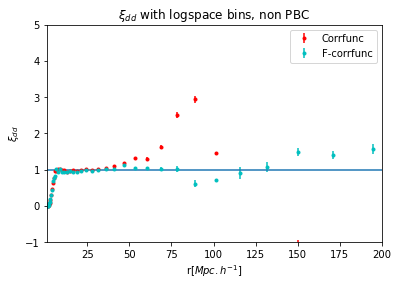

In [20]:
ax = plt.axes()
yy = np.full_like(r,1)
ax.plot(r,yy,'-')
ax.errorbar(r, xi/xi_dd_r_theory, fmt='r.', yerr = (1+xi)/np.sqrt(npair)/xi_dd_r_theory, label='Corrfunc')
ax.errorbar(r_f, xi_f/xi_dd_r_theory, fmt='c.', yerr = (1+xi_f)/np.sqrt(DD_f)/xi_dd_r_theory, label='F-corrfunc')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(1,2e2)
ax.set_ylim(-1,5)
ax.set_title('$\\xi_{dd}$ with logspace bins, non PBC')
#plt.savefig('xi_dd_logspace_nonPBC-compare14.png')

The 2nd simulation case: linear-space bins and non PBC

Adopt the random pair count from F-corrfunc to use for Corrfunc too.

The time measured here just the time for calculate DD pair count and $\xi$

Load my F-corrfunc results for non PBC, linearspace bins

Total duration time:  168.12684200000001       seconds.

Time for calculate only DD pair count: 79.143191000000002      seconds

In [ ]:
#load my F-corrfunc results for linear-space bins
xi_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-linearspace.txt', usecols = (3))
r_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-linearspace.txt', usecols = (2))
RR_f = np.loadtxt(path+'/my-f-code/results/xi-nonPBC-linearspace.txt', usecols = (1))
print(r_f)
print(xi_f)

In [ ]:
#for linear space bins
bins     = np.linspace(r_min, r_max, nbins + 1)

start_time3 = datetime.now()

#load positions of objects
X = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/11/gals/2gpc/R111_S014_clu_d.cat', usecols = (3))
    
weights = np.full_like(X,1)
#calculate data-data pairs
results_DD = DD(autocorr,
                nthreads,
                bins,
                X, Y, Z,
                weights1 = weights,
                boxsize=boxsize,
                weight_type = 'pair_product',
                output_ravg=True,
                periodic=False) 

#calculate random-random pairs in PBC case
N_halo = len(X)

npair  = results_DD['npairs']
weight = results_DD['weightavg']
xi  = npair*weight/RR_f - 1
r   = results_DD['ravg']

end_time3 = datetime.now()
print('Duration: {}'.format(end_time3 - start_time3))

In [ ]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(r, xi, 'b-', label='Corrfunc')
ax.plot(r, xi_dd_r_theory,'b--',label='Linear theory')
ax.plot(r_f, xi_f,'r.',label='F-corrfunc')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_xlim(1,2e2)
ax.set_title('$\\xi_{dd}$  with linear-space bins, non PBC')
plt.savefig('xi_dd_linspace_nonPBC.png')

PBC CASE

In [4]:
bins = np.logspace(np.log10(r_min), np.log10(r_max), nbins + 1)

#load positions of halos
X = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (1))
Y = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (2))
Z = np.loadtxt(path+'/catalogs/14/gals/2gpc/R114_S014_clu_d.cat', usecols = (3))
    
weights = np.full_like(X,1)
#calculate data-data pairs
results_DD = DD(autocorr,
                nthreads,
                bins,
                X, Y, Z,
                weights1    = weights,
                boxsize     = boxsize,
                weight_type = 'pair_product',
                output_ravg = True,
                periodic    = True) 

#calculate random-random pairs in PBC case
N_halo = len(X)

RR   = (4./3.*np.pi*(bins[1::]**3 - bins[0:-1:]**3))*N_halo*(N_halo-1)/boxsize**3
 
npair  = results_DD['npairs']
weight = results_DD['weightavg']
xi  = npair*weight/RR - 1
r   = results_DD['ravg']


In [35]:
xi_f = np.loadtxt(path+'/my-f-code/results/xi-PBC-test.txt', usecols = (3))
r_f = np.loadtxt(path+'/my-f-code/results/xi-PBC-test.txt', usecols = (2))
xi_f_nonPBC = np.loadtxt(path+'/my-f-code/results/xi-nonPBC2.txt', usecols = (3))
r_f_nonPBC  = np.loadtxt(path+'/my-f-code/results/xi-nonPBC2.txt', usecols = (2))

In [6]:
# Linear theory
b = 3.11
k   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (0))
P   = np.loadtxt(path+'/results/power_spectrum.txt', usecols = (1))
P_k = spline(k, P)
h0  = HankelTransform(nu=1/2, N = 2000, h = 1e-3)

# xi density in real space
f_0 = lambda k: P_k(k)*k**(1/2)/(np.pi*2)**(3/2)
xi_dd_r_theory = 1/np.sqrt(r_f)*h0.transform(f_0,r_f, ret_err=False, inverse=True)*b**2

Text(0.5, 1.0, '$\\xi_{dd}$ in real space, PBC')

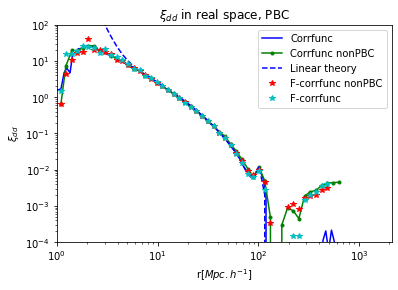

In [36]:
ax = plt.axes()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(r, xi, 'b-', label='Corrfunc')
ax.plot(r_nonPBC, xi_nonPBC, 'g.-', label='Corrfunc nonPBC')
ax.plot(r_f, xi_dd_r_theory,'b--',label='Linear theory')
ax.plot(r_f_nonPBC, xi_f_nonPBC,'r*',label='F-corrfunc nonPBC')
ax.plot(r_f, xi_f,'c*',label='F-corrfunc')
ax.set_ylabel("$\\xi_{dd}$ ")
ax.set_xlabel("r$[Mpc.h^{-1}]$")
ax.legend()
ax.set_ylim(1e-4,1e2)
ax.set_xlim(1,)
ax.set_title('$\\xi_{dd}$ in real space, PBC')
